# Variational AutoEncoder


## Setup

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Define dataset paths
pepsi_train_path = "/content/drive/MyDrive/CocaVsPepsi/processed_dataset/pepsi/train-pepsi"
coca_train_path = "/content/drive/MyDrive/CocaVsPepsi/processed_dataset/coca/train-coca"
img_size = (128, 128)

# Load and preprocess the images
def load_images(folder):
    images = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize the image to [0, 1]
        images.append(img)
    return np.array(images)

# Load pepsi and coca images
pepsi_images = load_images(pepsi_train_path)
coca_images = load_images(coca_train_path)

# Combine the images into a single dataset (pepsi and coca)
X_train = np.concatenate([pepsi_images, coca_images], axis=0)

# plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))
# plt.show()


## Create a sampling layer

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [ ]:

latent_dim = 64

encoder_inputs = keras.Input(shape=(128, 128, 3))

# Bloque 1
x = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

# Bloque 2
x = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

# Bloque 3
x = layers.Conv2D(128, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)


# Bloque 4
x = layers.Conv2D(512, 3, strides=1, padding="same", activation="relu")(x)
x = layers.Conv2D(512, 3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

# Regularización con Dropout
x = layers.Dropout(0.4)(x)

# Aplanar características
x = layers.Flatten()(x)

# Capa densa con regularización L2
x = layers.Dense(256, activation="tanh", kernel_regularizer=keras.regularizers.l2(0.005))(x)
x = layers.Dropout(0.4)(x)

# Capa densa intermedia
x = layers.Dense(128, activation="relu")(x)

# Capa de salida para media y varianza logarítmica
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Muestreo usando la reparametrización
z = Sampling()([z_mean, z_log_var])

# Construcción del modelo
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 32)   │            896 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 64, 64, 32)     │            128 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 32, 32, 64)     │            256 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 16, 16, 128)    │            512 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 16, 16, 512)    │        590,336 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 8, 8, 512)      │          2,048 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 32768)          │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 256)            │      8,388,864 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_3[0][0]          │
├──────────────────────

 Total params: 11,678,368 (44.55 MB)

 Trainable params: 11,676,896 (44.54 MB)

 Non-trainable params: 1,472 (5.75 KB)

## Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))

# Capa densa para expandir el espacio latente
x = layers.Dense(16 * 16 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 256))(x)

#Bloque 1
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

# Bloque 2
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)


# Bloque 3
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)

# Bloque 4
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# Regularización con Dropout para evitar sobreajuste
x = layers.Dropout(0.3)(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Construcción del modelo
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 65536)               │       4,259,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 128)         │         147,584 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 128, 128, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_12                  │ (None, 128, 128, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 128, 128, 3)         │             867 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,977,667 (22.80 MB)

 Trainable params: 5,976,707 (22.80 MB)

 Non-trainable params: 960 (3.75 KB)

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:
from tensorflow.keras.saving import serialize_keras_object



class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.MSE(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss * 0.5

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": serialize_keras_object(self.encoder),
            "decoder": serialize_keras_object(self.decoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Reconstruye encoder y decoder al cargar el modelo."""
        config["encoder"] = keras.saving.deserialize_keras_object(config["encoder"])
        config["decoder"] = keras.saving.deserialize_keras_object(config["decoder"])
        return cls(**config)


## Train the VAE

In [ ]:
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

wandb.init(project="autoencoder-Variational", config={
    "epochs": 500,
    "img_size": img_size,
    "architecture": "autoencoder",
    "dataset": "city and forest",

})

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: loother (loother-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
wandb_callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(f"/content/drive/MyDrive/CocaVsPepsi/models/variational/vae-{wandb.run.name}.h5",
                          monitor="loss",
                          save_best_only=True,
                          mode="min",
                          verbose=1)
]

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
vae.trainable = True
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(X_train, epochs=wandb.config.epochs, batch_size=128, callbacks=wandb_callbacks)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - kl_loss: 17.0846 - loss: 14.2363 - reconstruction_loss: 5.6941
Epoch 1: loss did not improve from 13.72031
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - kl_loss: 17.0846 - loss: 14.2363 - reconstruction_loss: 5.6941
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - kl_loss: 17.6712 - loss: 207.6802 - reconstruction_loss: 198.8446
Epoch 2: loss did not improve from 13.72031
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - kl_loss: 17.6712 - loss: 207.6802 - reconstruction_loss: 198.8446   
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - kl_loss: 18.0416 - loss: 40.7517 - reconstruction_loss: 31.7309
Epoch 3: loss did not improve from 13.72031
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - kl_loss: 18.0416 - loss: 40.7517 - reconstruction_loss: 31.7309   
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - kl_loss: 19.0709 - loss: 90.9298 - reconstruction_loss: 81.3944
Epoch 4: loss did not improve from 13.72031
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - kl_l

In [ ]:
vae.save(
    f'/content/drive/MyDrive/CocaVsPepsi/models/variational/vae-{wandb.run.name}.h5'
)

In [ ]:
from tensorflow import keras

vae = keras.models.load_model(f'/content/drive/MyDrive/CocaVsPepsi/models/variational/vae-{wandb.run.name}.h5', custom_objects={"VAE": VAE, "Sampling": Sampling})


## Display a grid of sampled digits

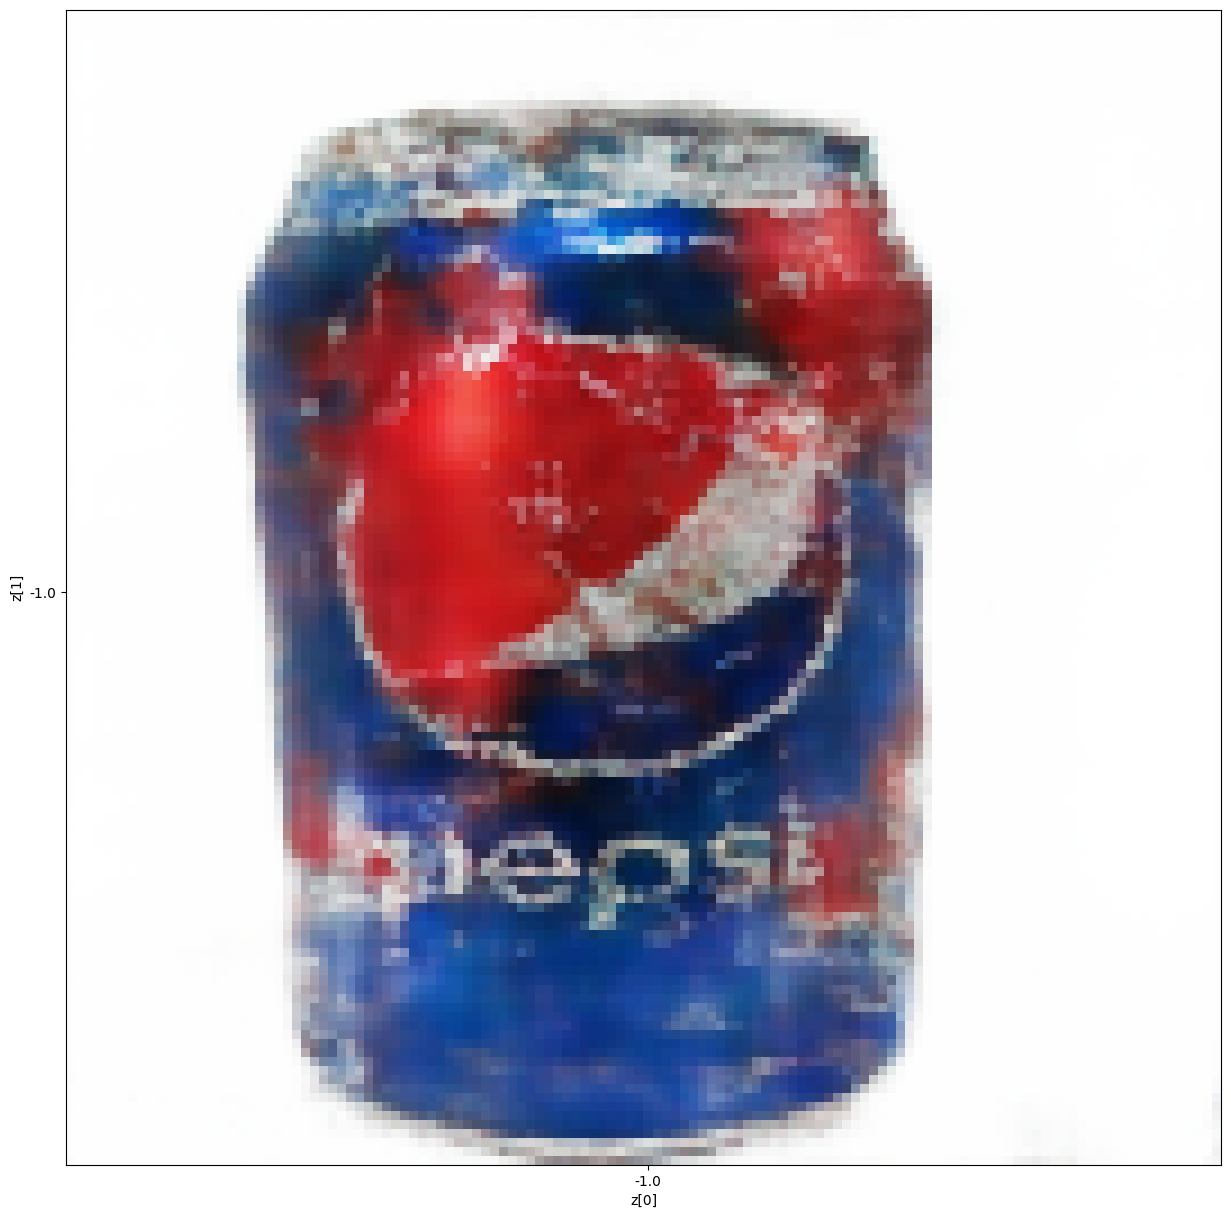

In [ ]:
latent_dim = 64


def generate_new(vae, n=1, figsize=15):

  digit_size = 128
  scale = 1.0
  figure = np.zeros((digit_size * n, digit_size * n, 3), dtype=np.uint8)

  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i in range(n):
    for j in range(n):
      z_sample = np.random.normal(size=(1, latent_dim))
      x_decoded = vae.decoder.predict(z_sample, verbose=0)
      digit = x_decoded[0].reshape(digit_size, digit_size,3)
      digit = np.clip(digit * 255, 0, 255).astype(np.uint8)
      figure[
          i * digit_size : (i + 1) * digit_size,
          j * digit_size : (j + 1) * digit_size,
      ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(cv2.cvtColor(figure, cv2.COLOR_BGR2RGB))
  plt.show()

generate_new(vae)

In [ ]:
import tensorflow as tf
from scipy.linalg import sqrtm
import numpy as np

def get_inception_features(images):
    # Cargar el modelo preentrenado InceptionV3
    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))
    images = tf.image.resize(images, (128, 128))
    images = tf.keras.applications.inception_v3.preprocess_input(images)  # Preprocesar imágenes
    features = inception_model.predict(images)
    return features

# Función para calcular el FID
def calculate_fid(real_images, generated_images):
    real_features = get_inception_features(real_images)
    generated_features = get_inception_features(generated_images)

    # Calcular la media y la covarianza de las características reales
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    # Calcular la media y la covarianza de las características generadas
    mu_generated = np.mean(generated_features, axis=0)
    sigma_generated = np.cov(generated_features, rowvar=False)

    # Calcular la distancia de Fréchet
    diff = mu_real - mu_generated
    covmean = sqrtm(sigma_real.dot(sigma_generated))

    # En algunos casos el resultado puede ser complejo, tomamos la parte real
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = np.sum(diff**2) + np.trace(sigma_real + sigma_generated - 2.0 * covmean)
    return fid

In [ ]:

# Función para obtener imágenes generadas
def generate_images(vae, n=100):
    latent_dim = 64
    z_samples = np.random.normal(size=(n, latent_dim))  # Muestras del espacio latente
    generated_images = vae.decoder.predict(z_samples)
    return generated_images


In [ ]:
# Obtener imágenes generadas
generated_images = generate_images(vae)

# Evaluar FID usando las imágenes reales y generadas
fid_score = calculate_fid(X_train, generated_images)
print("FID Score:", fid_score)